In [1]:
from src.synthgen import SyntheticDatasetGenerator
import matplotlib.pyplot as plt
from src.models.ARIMA import ARIMA
from src.models.baseline import NaiveForecast
from src.models.baseline import AverageForecast
from src.parser import parser
from src.models.FITS import FITS
import numpy as np
import torch
import torch.nn as nn

%config InlineBackend.figure_format='retina'

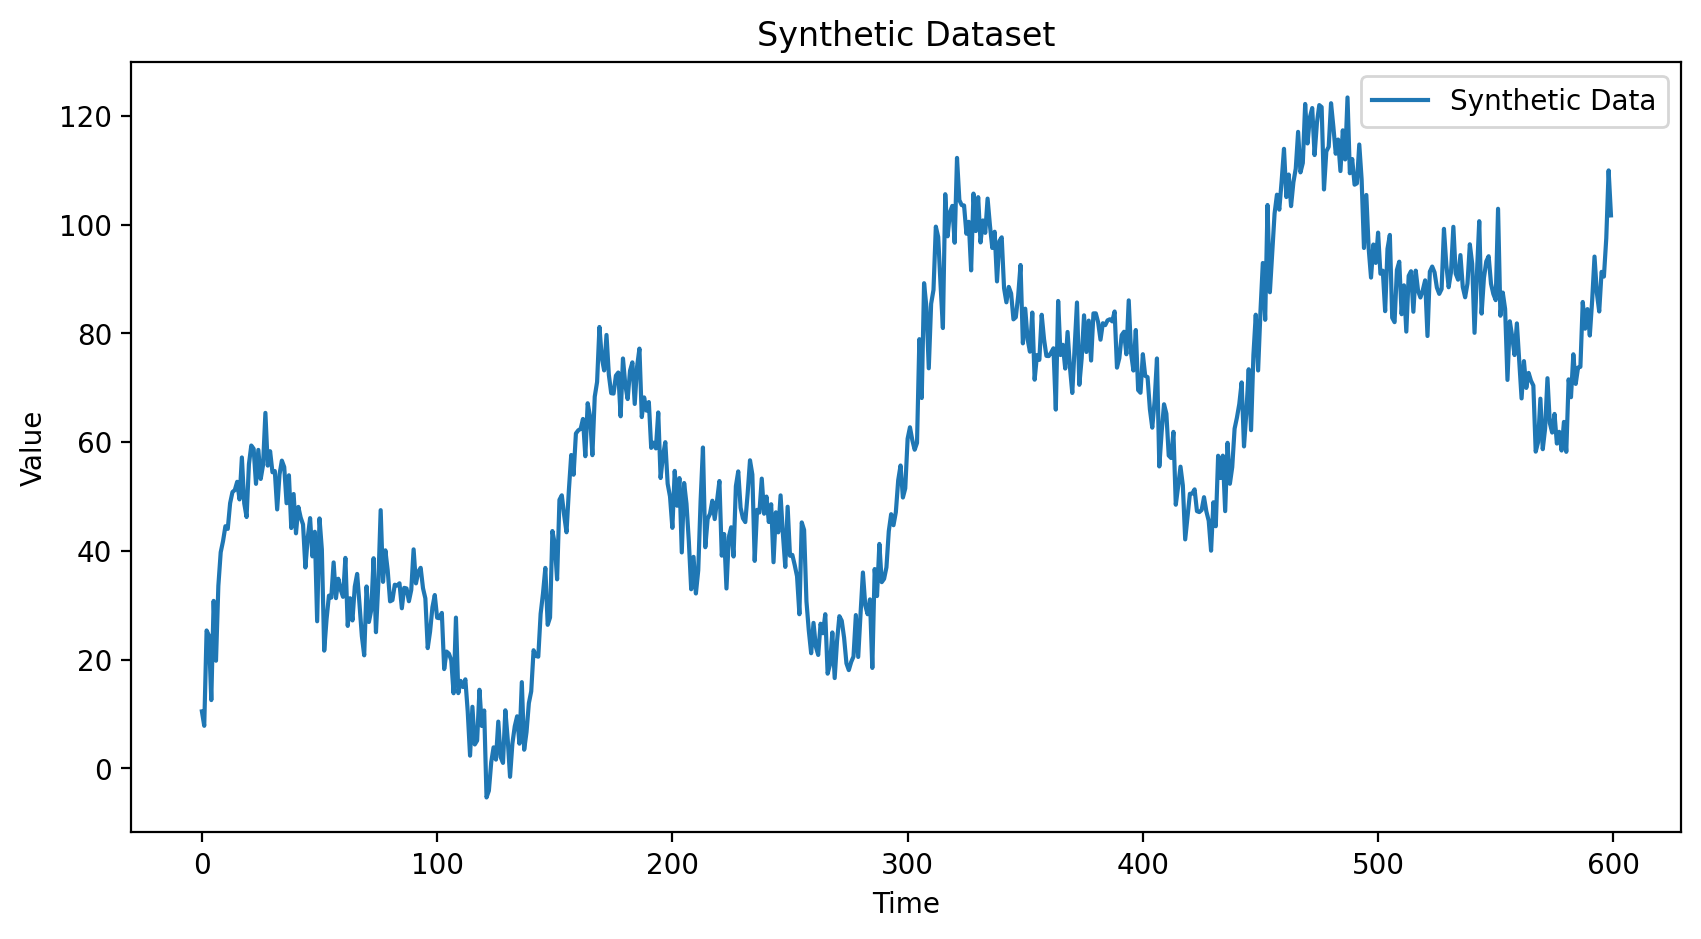

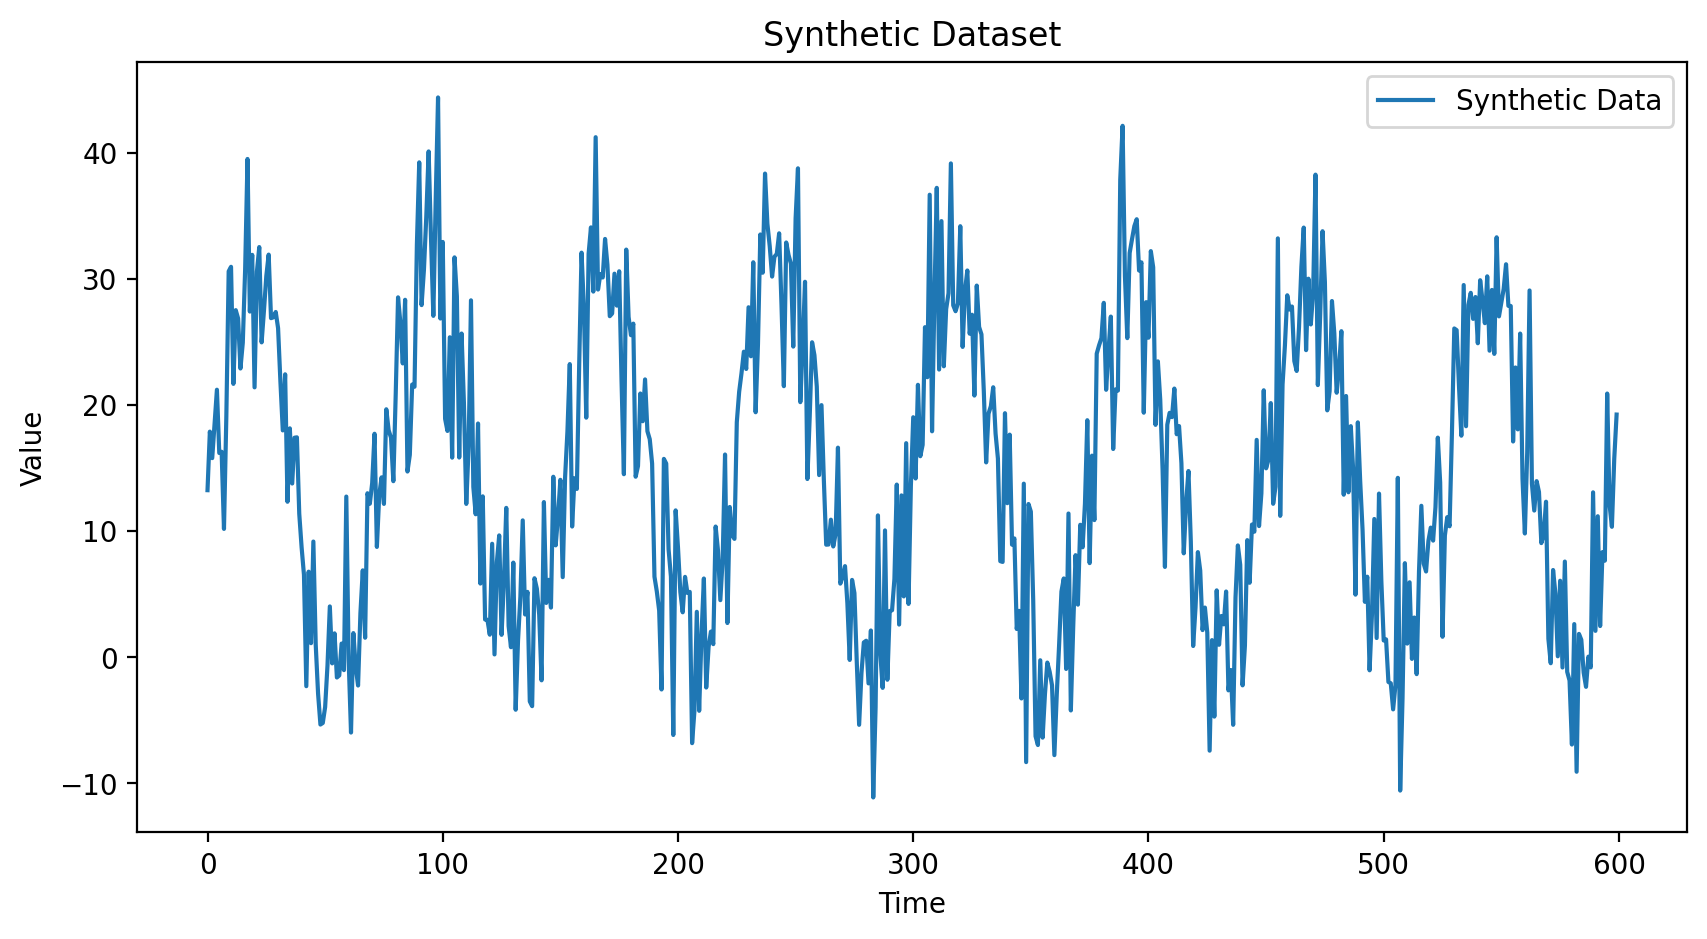

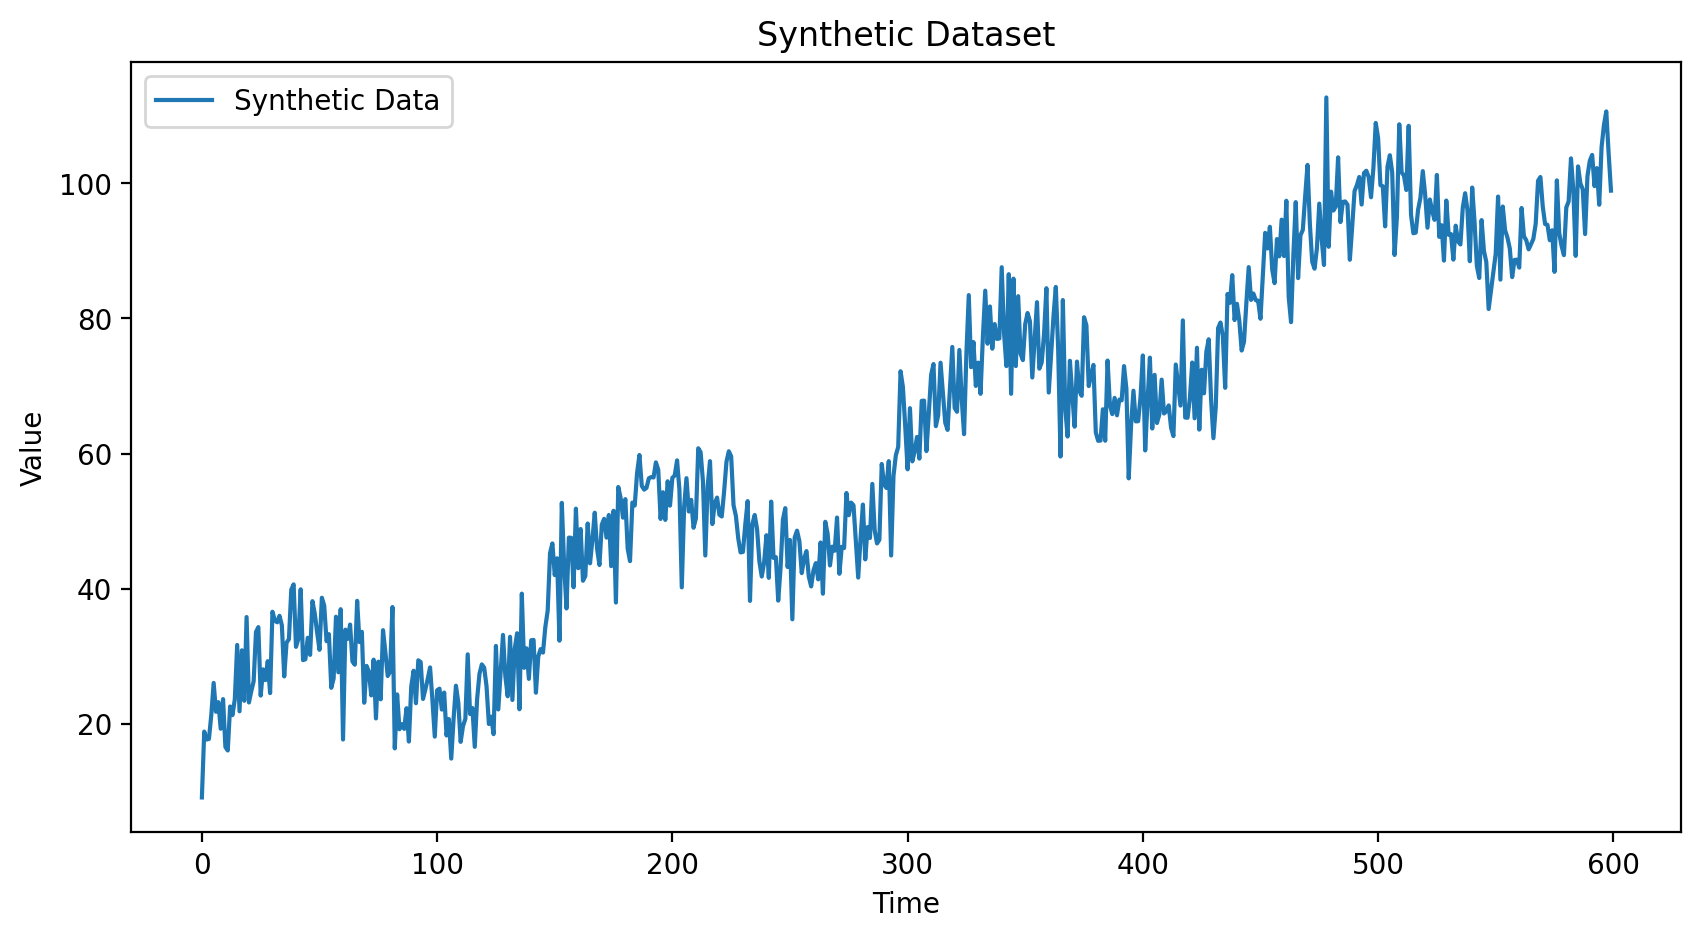

In [7]:
SiusesNoisy = SyntheticDatasetGenerator(length=600)
SiusesNoisy.add_sin_wave(amplitude=15, frequency=8)
SiusesNoisy.add_sin_wave(amplitude=5, frequency=2)
SiusesNoisy.add_sin_wave(amplitude=25, frequency=4)
SiusesNoisy.add_noise(mean=15, std=5)
SiusesNoisy.add_linear_trend(0.15, intercept=1)
SiusesNoisy.plot_data()

SiusNoisy = SyntheticDatasetGenerator(length=600)
SiusNoisy.add_sin_wave(amplitude=15, frequency=8)
SiusNoisy.add_noise(mean=15, std=5)
SiusNoisy.plot_data()

LinearSin = SyntheticDatasetGenerator(length=600)
LinearSin.add_sin_wave(amplitude=10, frequency=4)
LinearSin.add_linear_trend(0.15, intercept=1)
LinearSin.add_noise(mean=15, std=5)
LinearSin.plot_data()

In [83]:
train_data_sinuses, test_data_sinuses = SiusesNoisy.data[:400], SiusesNoisy.data[400:]
train_data_sinus, test_data_sinus = SiusNoisy.data[:400], SiusNoisy.data[400:]

args = parser.parse_args(["--pred_len", "200", "seq_len", "400", "--debug"])

naive = NaiveForecast(args)
arima = ARIMA(args)
average = AverageForecast(args)

datas = [(train_data_sinuses, test_data_sinuses), (train_data_sinus, test_data_sinus)]
models = [("NF", naive), ("ARIMA", arima), ("Average", average)]


cpu
cpu
cpu
cpu


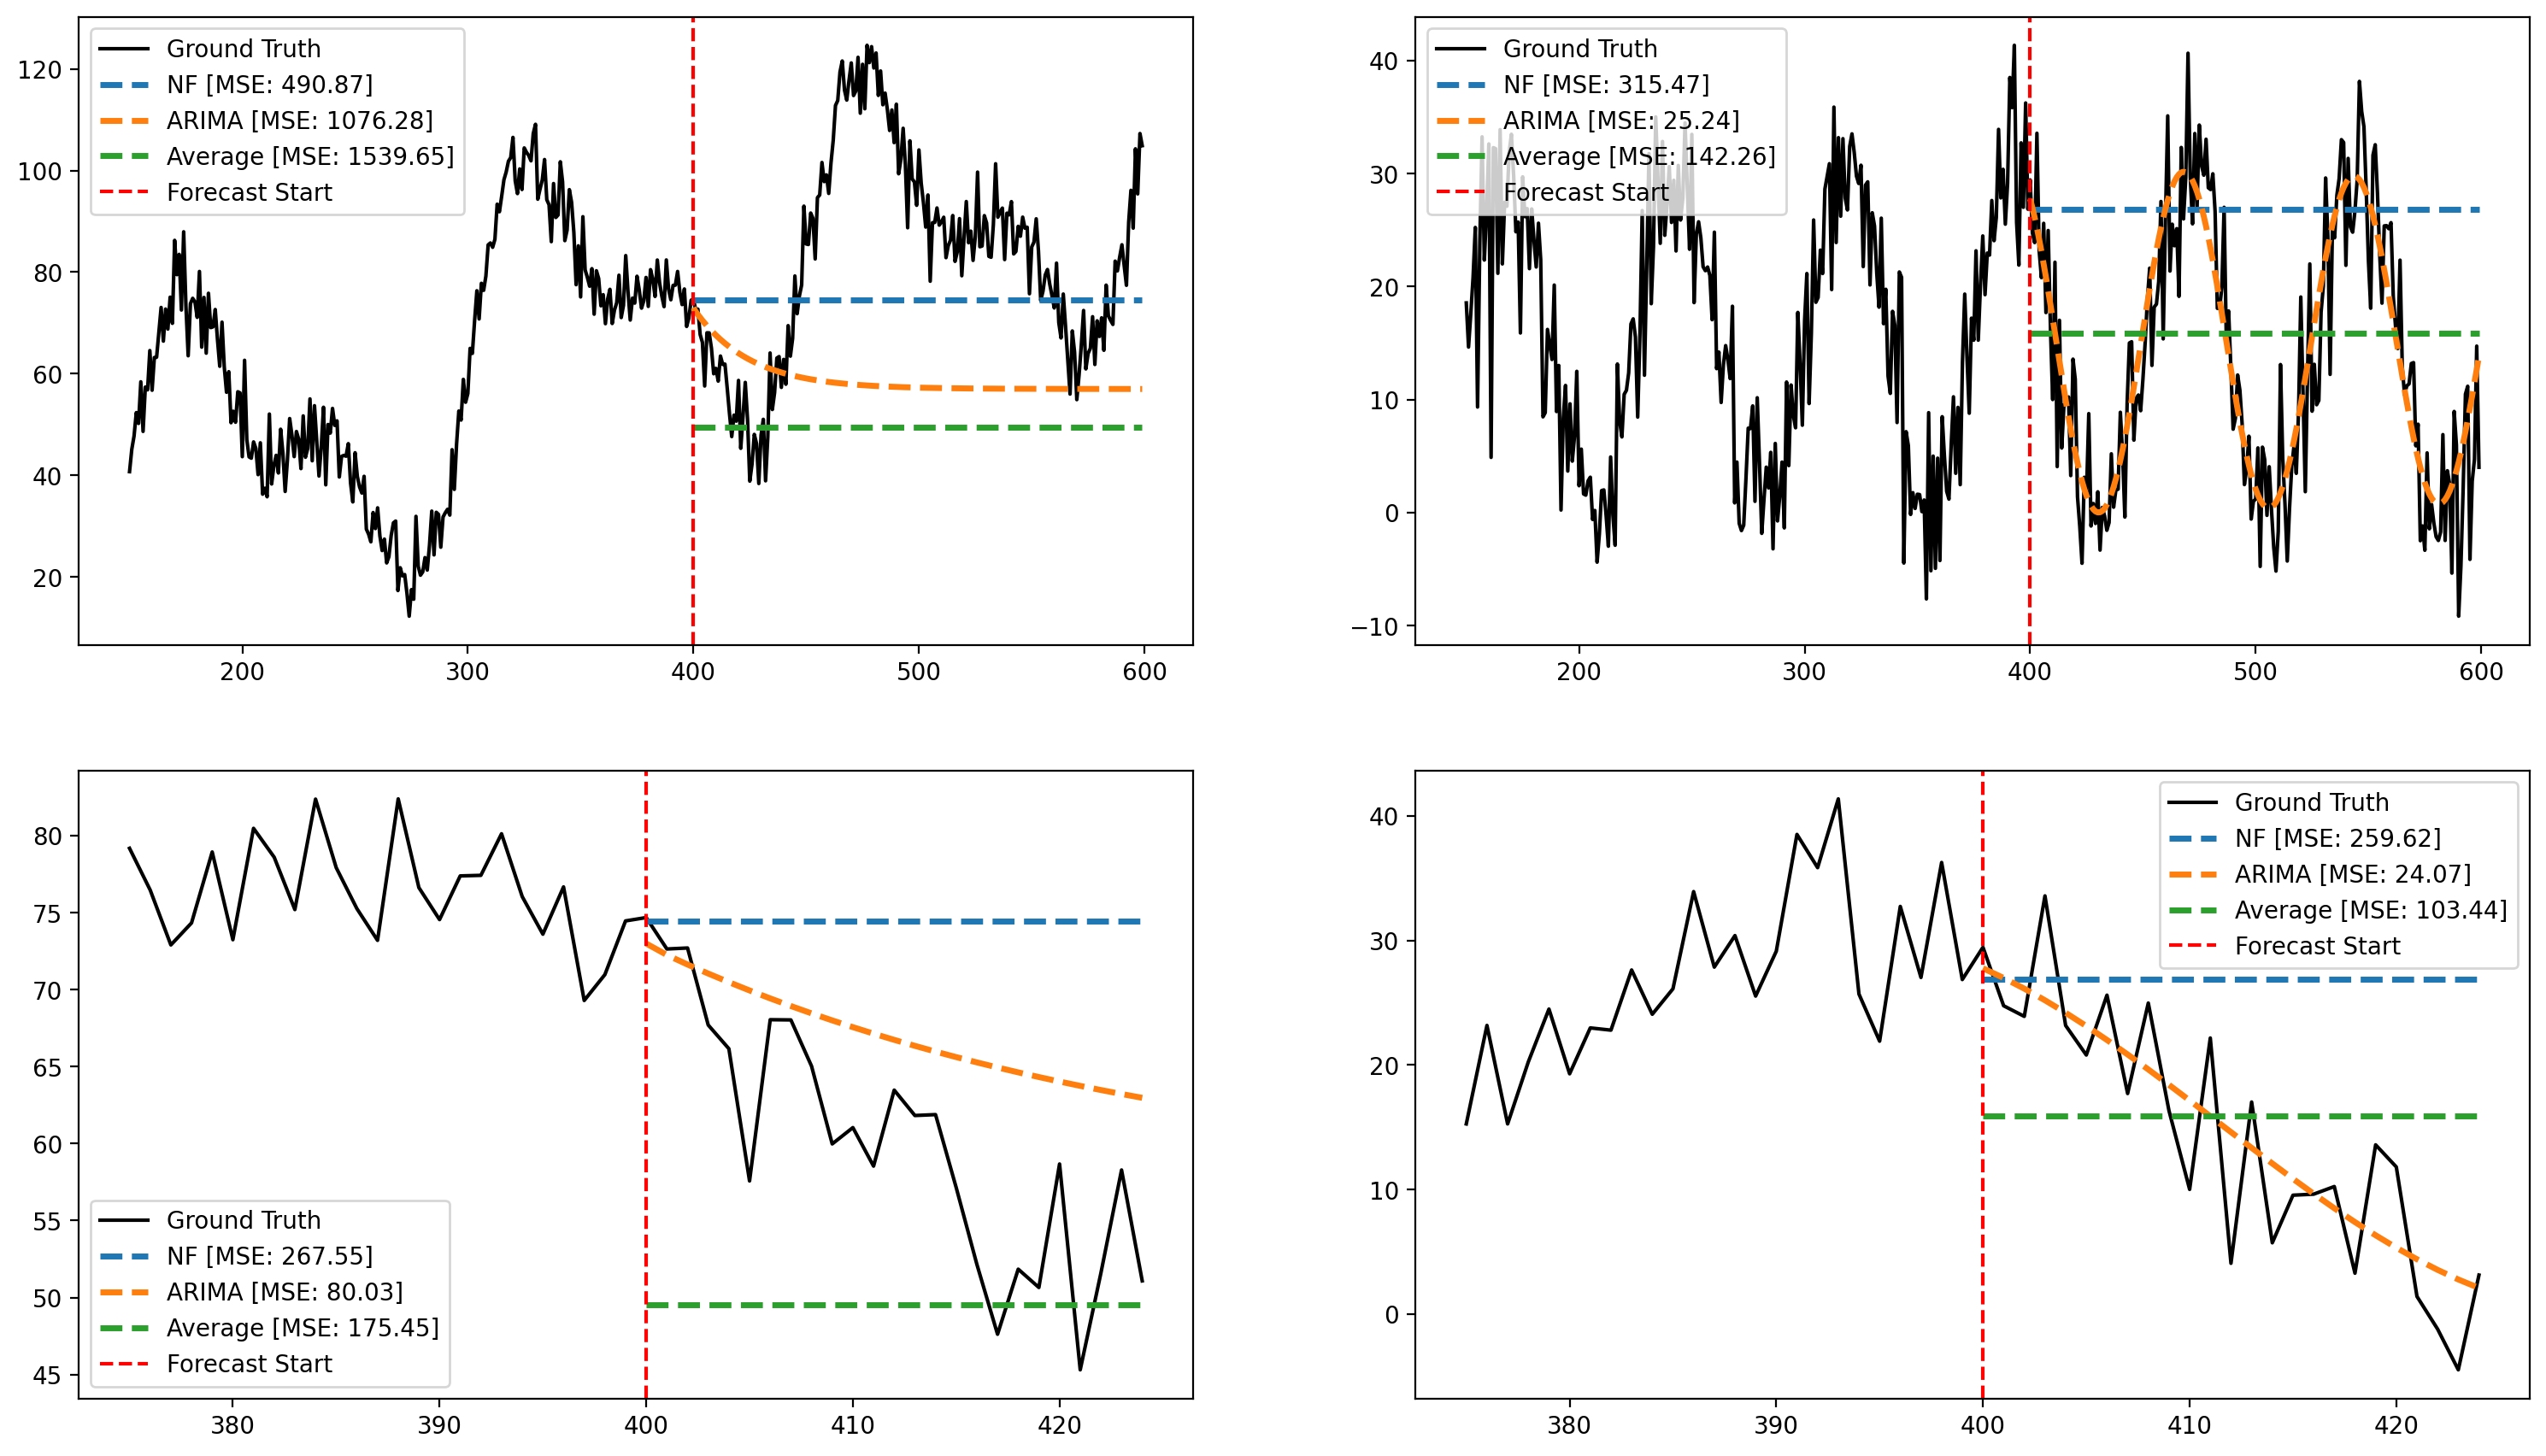

In [103]:
start_end_indices = [(150, 600), (375, 425)]
figure, axes = plt.subplots(2, 2)
for i, (start_index, end_index) in enumerate(start_end_indices):
    for j, (train_data, test_data) in enumerate(datas):
        real_data = np.concatenate((train_data[start_index:], test_data[:end_index-400]), axis=0)
        axes[i,j].plot(list(range(start_index,end_index)), real_data, label="Ground Truth", color="black")
        for name, model in models:
            with torch.no_grad():
                def RMAE(output, target):
                    return torch.sqrt(torch.mean(torch.abs(output - target)))
                
                criterion_mse = nn.MSELoss()
                criterion_rmae = RMAE


                naive.eval()
                test_loss_mse = []
                test_loss_rmae = []

                batch_x = torch.from_numpy(train_data.reshape(-1, 400, 1))
                batch_y = torch.from_numpy(test_data.reshape(-1, 200, 1))
                batch_xy = torch.cat([batch_x, batch_y], dim=1)
                output = model(batch_x)
                if name == "ARIMA":
                    output = output[:, :end_index-400, 0:]
                else:
                    output = output[:, 400:end_index, 0:]
                batch_y = batch_y[:, :end_index-400, 0:]
                loss_mse = criterion_mse(output, batch_y)
                loss_rmae = criterion_rmae(output, batch_y)
                test_loss_mse.append(loss_mse.item())
                test_loss_rmae.append(loss_rmae.item())

            axes[i, j].plot(list(range(400, end_index)), output[0, :end_index-400, 0], label=f"{name} [MSE: {round(loss_mse.item(),2)}]", linewidth=2.5, linestyle="--")
        axes[i, j].axvline(x=400, color="red", linestyle="--", label="Forecast Start")
        axes[i, j].legend()
        axes[i, j].grid(show=True)
figure.set_size_inches(18.5, 10.5)
plt.legend()
plt.show()

In [ ]:
model = FITS(args)